## Tiled, fixed resolution grids 

`yt_experiments` includes a number of data objects for generating fixed resolution, grid-aligned samples subdivided into chunks. These objects are generally comprised of a number of individual `YTArbitraryGrid` objects assembled in a regular fashion. These objects can be used to generate, for example, a tiled Zarr array of a field in a yt dataset, including hierarchical tiling, which can be useful for resampling a yt dataset for use with other tools. 

Defined in `yt_experiments.tiled_grid`, we have:

* `YTTiledArbitraryGrid`: a tiling of adjacent `YTArbitaryGridObjects`
* `YTArbitraryGridPyramid`: an image pyramid object built from a series of `YTTiledArbitraryGrid` defined at different resolutions
* `YTArbitraryGridOctPyramid`: a special case of `YTArbitraryGridPyramid`, in which you specify the image base dimensions, the desired number of levels and the refinement between levels (by default, 2, resulting in an octree image pyramid). 

Note that in the pyramid objects, the base level 0 is the highest resolution level (as opposed to yt grid-based datasets, in which level 0 is the coarsest resolution). 


In [42]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import yt
import zarr

from yt_experiments.tiled_grid import (
    YTArbitraryGridOctPyramid,
    YTArbitraryGridPyramid,
    YTTiledArbitraryGrid,
)

In [2]:
def initialize_store(store_name: str, rm_existing: bool = True):
    """
    initialize a top level on-disk zarr store, optionally
    deleting existing store at the same location. If you
    have the yt test_data_dir set, will initialize at
    test_data_dir / store_name, otherwise will initialize in the
    current directory
    """
    store_dir = yt.config.ytcfg.get("yt", "test_data_dir")
    if store_dir == yt.config.ytcfg_defaults["yt"]["test_data_dir"]:
        store_dir = os.curdir
    store_top = os.path.join(store_dir, store_name)
    if os.path.exists(store_top) and rm_existing:
        shutil.rmtree(store_top)
    zarr_store = zarr.group(store_top)
    return zarr_store

In [3]:
ds = yt.load_sample("DeeplyNestedZoom")

yt : [INFO     ] 2025-04-17 09:37:48,549 Sample dataset found in '/Users/chavlin/data/yt_data/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2025-04-17 09:37:48,659 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2025-04-17 09:37:48,660 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-04-17 09:37:48,660 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-04-17 09:37:48,660 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-04-17 09:37:48,661 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-04-17 09:37:48,661 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2025-04-17 09:37:48,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-04-17 09:37:48,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-04-17 09:37:48,661 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-04-17 09:37:48,662 Parameters: hubb

## creating a single tiled grid in memory

We'll start with a simple case that is not useful in practice but is good for demonstrating usage: generating a tiled grid in memory (if it fits in memory, one can simply use a YTArbitraryGrid). 

In [6]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge,
    ds.domain_right_edge,
    (400, 400, 400),
    100,
    ds=ds,
)
tag

YTTiledArbitraryGrid with total shape of (400, 400, 400) divided into 64 grids: (4, 4, 4) grids in each dimension.

To extract a uniform numpy array:

In [7]:
vals = tag.to_array(
    ("gas", "density"),
)
print(vals.shape)

Parsing Hierarchy : 100%|████████████████████████████████████████████████████████| 1825/1825 [00:00<00:00, 16028.30it/s]
yt : [INFO     ] 2025-03-25 15:52:26,359 Gathering a field list (this may take a moment.)


(400, 400, 400)


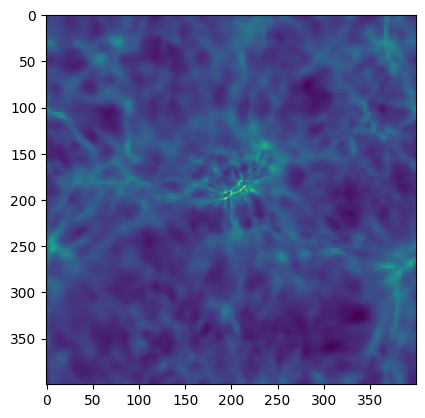

In [8]:
plt.imshow(np.log10(vals[:, :, 200]))

The tiled grid objects provide the ability to apply functions by-chunk (beware units!!)

In [11]:
vals = tag.to_array(
    ("gas", "density"),
    ops=[
        np.log10,
    ],
)
vals[0:10, 0, 0]

unyt_array([-26.92235472, -26.92235472], 'g/cm**3')

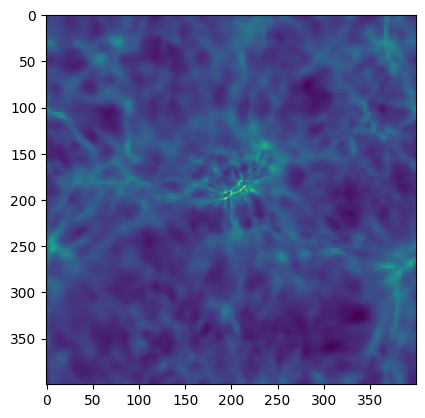

In [12]:
plt.imshow(vals[:, :, 200])

## A single tiled grid, larger-than memory on-disk zarr

Now for a more interesting example. In this case, we'll build a tiled grid to represent a larger-than-memory array:

In [9]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge, ds.domain_right_edge, (2000, 2000, 2000), 100, ds=ds
)

We can use the tiled grid to convert a field to a zarr array by first initializing an on-disk zarr store:

In [10]:
zarr_store = initialize_store("tiled_grid_full.zarr")
zarr_store

<zarr.hierarchy.Group '/'>

and creating an empty array to fill using the tile grid dimensions and chunk information

In [11]:
tag.dims, tag.chunks

(array([2000, 2000, 2000]), array([100, 100, 100]))

In [12]:
zarr_field = zarr_store.empty("gas_density", shape=tag.dims, chunks=tag.chunks)

In [13]:
zarr_field

<zarr.core.Array '/gas_density' (2000, 2000, 2000) float64>

Now, we can provide this zarr array as the `output_array` to store the tiled grids in, and the tiled grid object will iterate over the individual grids and write them to the appropriate zarr chunk:

In [14]:
%%time
_ = tag.to_array(
    ("gas", "density"),
    output_array=zarr_field,
    ops=[
        np.log10,
    ],
)

CPU times: user 1min 19s, sys: 12 s, total: 1min 31s
Wall time: 1min 6s


and we can now check out our zarr array:

In [15]:
zarr_field.info

Name,/gas_density
Type,zarr.core.Array
Data type,float64
Shape,"(2000, 2000, 2000)"
Chunk shape,"(100, 100, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,64000000000 (59.6G)
No. bytes stored,1169123997 (1.1G)


For reference, each chunk of the zarr array is on disk, e.g.:

In [16]:
os.listdir(os.path.join(zarr_store.store.path, "gas_density"))[:10]

['15.17.8',
 '16.10.16',
 '5.8.10',
 '3.16.4',
 '8.10.11',
 '0.5.11',
 '10.11.17',
 '4.7.0',
 '5.13.7',
 '15.16.12']

And chunks will only be loaded in memory when needed for the index ranges requested:

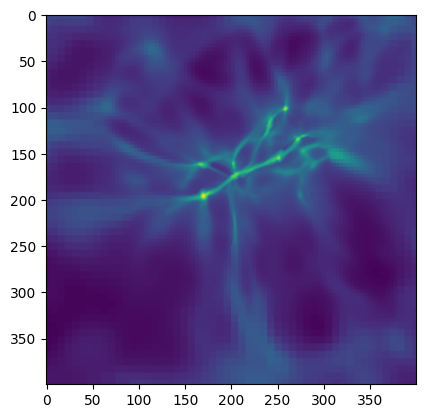

In [17]:
plt.imshow(zarr_field[800:1200, 800:1200, 1000])

## Constructing Image Pyramids

The image pyramid objects, `YTArbitraryGridPyramid` and `YTArbitraryGridOctPyramid` provide a mechanism for resampling a yt field as a regularized image pyramid, which can be useful for leveraging other visualization and analysis libraries. 

To use `YTArbitraryGridPyramid`, you provide a sequence of decreasing image resolutions (again, the base level 0 image is the **highest** resolution):

In [4]:
level_dims = [(res,) * 3 for res in range(1000, 200, -200)]
level_dims

[(1000, 1000, 1000), (800, 800, 800), (600, 600, 600), (400, 400, 400)]

And specify the chunk size for each level. A single value will use the same chunk size across pyramid levels:

In [5]:
level_chunks = 200

In [6]:
pyr = YTArbitraryGridPyramid(
    ds.domain_left_edge, ds.domain_right_edge, level_dims, level_chunks, ds=ds
)

individual levels are comprised of `YTTiledArbitraryGrid` objects, accessible by indexing the object:

In [7]:
pyr[0]

YTTiledArbitraryGrid with total shape of (1000, 1000, 1000) divided into 125 grids: (5, 5, 5) grids in each dimension.

or indexing the `levels` attribute:

In [8]:
pyr.levels[0]

YTTiledArbitraryGrid with total shape of (1000, 1000, 1000) divided into 125 grids: (5, 5, 5) grids in each dimension.

This can similarly be written to a zarr array utilizing the `to_zarr` method. First, initialize an on-disk store:

In [16]:
zarr_store = initialize_store("deeply_nested_pyramid.zarr", rm_existing=True)

now, we initialize a group to nest all the levels under

In [17]:
zarr_group = zarr_store.create_group("gas_density")

and initialized the zarr arrays for each level

In [18]:
arrays_to_fill = [
    zarr_group.empty(str(lev), shape=tag.dims, chunks=tag.chunks, dtype=np.float32)
    for lev, tag in enumerate(pyr.levels)
]
arrays_to_fill

[<zarr.core.Array '/gas_density/0' (1000, 1000, 1000) float32>,
 <zarr.core.Array '/gas_density/1' (800, 800, 800) float32>,
 <zarr.core.Array '/gas_density/2' (600, 600, 600) float32>,
 <zarr.core.Array '/gas_density/3' (400, 400, 400) float32>]

note we initialized our arrays to float32 and will downcast to float32 iin the next call by providing a dtype argument. This is because many image libraries that handle pyramidal images end up downcasting for GPU rendering, so we might as well save a little space now. 

In [19]:
%%time
pyr.to_arrays(
    ("gas", "density"),
    arrays_to_fill,
    dtype=np.float32,
    ops=[
        np.log10,
    ],
)

CPU times: user 18.1 s, sys: 3.25 s, total: 21.4 s
Wall time: 18.2 s


[<zarr.core.Array '/gas_density/0' (1000, 1000, 1000) float32>,
 <zarr.core.Array '/gas_density/1' (800, 800, 800) float32>,
 <zarr.core.Array '/gas_density/2' (600, 600, 600) float32>,
 <zarr.core.Array '/gas_density/3' (400, 400, 400) float32>]

and let's check that our levels are filled:

In [20]:
zarr_store["gas_density"]["0"].info

Name,/gas_density/0
Type,zarr.core.Array
Data type,float32
Shape,"(1000, 1000, 1000)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,4000000000 (3.7G)
No. bytes stored,240431976 (229.3M)


In [21]:
zarr_store["gas_density"]["3"].info

Name,/gas_density/3
Type,zarr.core.Array
Data type,float32
Shape,"(400, 400, 400)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,256000000 (244.1M)
No. bytes stored,69191339 (66.0M)


Now let's plot up a zoomed in view for each level, starting with the coarsest (highest) level and moving to the finest resolution:

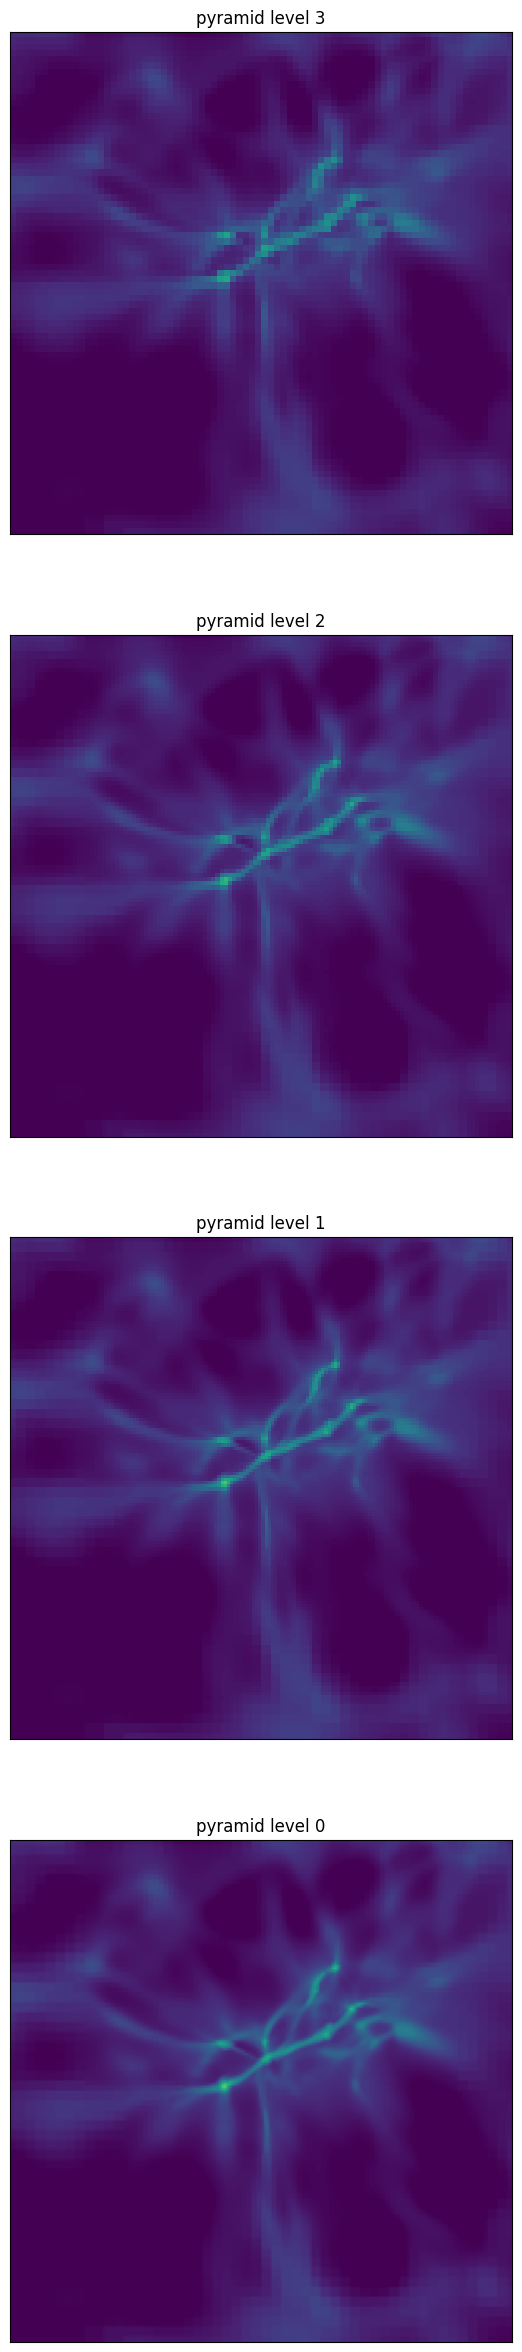

In [40]:
maxlevels = pyr.n_levels

f, axs = plt.subplots(ncols=1, nrows=maxlevels, figsize=(10, 30))
extent = (0, 1, 0, 1)

for ilevel in range(maxlevels):
    vals_3d = zarr_store["gas_density"][str(ilevel)]
    shp = vals_3d.shape
    iplot = (maxlevels - 1) - ilevel
    im = axs[iplot].imshow(
        vals_3d[:, :, int(vals_3d.shape[-1] / 2)], extent=extent, vmin=-27, vmax=-23
    )
    axs[iplot].set_xlim([0.4, 0.6])
    axs[iplot].set_ylim([0.4, 0.6])
    axs[iplot].xaxis.set_visible(False)
    axs[iplot].yaxis.set_visible(False)
    axs[iplot].set_title(f"pyramid level {ilevel}")

Using `YTArbitraryGridOctPyramid` is very similar, but with some assumptions built in to automatically refine between levels. 

First let's set our base level dimensions and chunks as powers of 2: 


In [86]:
base_dims = (2**11,) * 3
base_chunks = (64, 64, 64)

`YTArbitraryGridOctPyramid` does not currently allow partially filled chunks, so let's check how many refinements we can do with a factor of 2 between levels. What we want is the number of refinements , $n$, that result in a grid size equal to the `base_chunk`:

$ \mathrm{base_chunks} = \frac{\mathrm{base\_res}}{2^n} $

In [87]:
factor = 2  # the default
max_n_refinements = np.log(base_dims[0] / base_chunks[0]) / np.log(factor)
max_n_refinements

5.0

so our max number of levels, including the base level 0, is 6:

In [88]:
pyr = YTArbitraryGridOctPyramid(
    ds.domain_left_edge,
    ds.domain_right_edge,
    base_dims,
    base_chunks,
    ds=ds,
    factor=factor,
    n_levels=6,
)

and let's check the levels that would be generated:

In [89]:
pyr.levels

[YTTiledArbitraryGrid with total shape of (2048, 2048, 2048) divided into 32768 grids: (32, 32, 32) grids in each dimension.,
 YTTiledArbitraryGrid with total shape of (1024, 1024, 1024) divided into 4096 grids: (16, 16, 16) grids in each dimension.,
 YTTiledArbitraryGrid with total shape of (512, 512, 512) divided into 512 grids: (8, 8, 8) grids in each dimension.,
 YTTiledArbitraryGrid with total shape of (256, 256, 256) divided into 64 grids: (4, 4, 4) grids in each dimension.,
 YTTiledArbitraryGrid with total shape of (128, 128, 128) divided into 8 grids: (2, 2, 2) grids in each dimension.,
 YTTiledArbitraryGrid with total shape of (64, 64, 64) divided into 1 grids: (1, 1, 1) grids in each dimension.]

from here, generating filled zarr arrays is identical to `YTTiledArbitraryGrid`.